# gpstextbook homework 5.4

In [204]:
# !pip3 install seaborn

import pandas as pd
import numpy as np

%pylab inline
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml" # also try "html5" (requires ffmpeg)
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [152]:
frequency_L1 = 1575.42e6  # in Hz
frequency_L2 = 1227.60e6  # in Hz
avg_earth_radius = 6.3781e6  # in m
c0 = 299792458.0  # in m/s
omega_e_dot = 7.2921151467e-5  # in rad/s
wgs_mu = 3.986005e14  # m3 / s2

# pigeon point reference station position. all in meters
# ITRF96 POSITION (EPOCH 1997.0)
# Computed in Mar., 1998 using 46 days of data.
# latitude    =  37 11 13.50037 N
# longitude   = 122 23 23.81274 W
X_pigeon_point =  -2725252.943
Y_pigeon_point =  -4295977.239
Z_pigeon_point =   3833959.060

pigeon_point_pos = np.array([X_pigeon_point, Y_pigeon_point, Z_pigeon_point])

In [65]:
def read_rinex(path_rinex_file):
    return pd.read_csv(path_rinex_file, engine='python', delimiter='\s+', header=None, 
                       names=['gps_week', 'rx_week', 'prn', 'pseudoL1', 'cyclesL1', 'cyclesL2', 'pseudoP1', 
                      'pseudoP2', 'dopplerL1', 'dopplerL2'])

def read_rinex_nav(path_rinex_file):
    return pd.read_csv(path_rinex_file, engine='python', delimiter='\s+', header=None, 
                       names=['prn', 'm0', 'dn', 'e', 'sqrta', 'omg0', 'i0', 'w', 'odot', 'idot', 'cuc', 'cus', 'crc',
                      'crs', 'cic', 'cis', 'toe', 'iode', 'gps_week', 'toc', 'af0', 'af1', 'af2', 'wdot'])



In [17]:
def iono_group_delay(pseudorange_L1, pseudorange_L2, frequency_L1=frequency_L1, frequency_L2=frequency_L2):
    """This is in units of a distance (m)"""
    factor = pow(frequency_L2, 2) / (pow(frequency_L1, 2) - pow(frequency_L2, 2))
    
    def get_iono_group_delay(pseudorange_L1, pseudorange_L2):
        return factor * (pseudorange_L2 - pseudorange_L1)
    
    return get_iono_group_delay

In [139]:
def iono_obliquity_factor(zeta, avg_earth_radius=avg_earth_radius, h1=350e3):
    return pow(1. - pow((avg_earth_radius * sin(np.deg2rad(zeta))) / (avg_earth_radius + h1), 2), -0.5)

import math
def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
    return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

In [72]:
path_rinex_file = '/Users/guillaume/Workspace/gnss/data/Data/Pigeon_Point/September_18_2000/Parsed/pp091800.rio'
path_rinex_nav_file = '/Users/guillaume/Workspace/gnss/data/Data/Pigeon_Point/September_18_2000/Parsed/pp091800.rin'

df = read_rinex(path_rinex_file)
df_nav = read_rinex_nav(path_rinex_nav_file)

df['rx_week'].max()


172812.946

In [97]:
df_nav.loc[(df_nav.prn == 3) & (df_nav.toe<95443) , :].iloc[-1].to_dict()

{'af0': 4.09870408475e-05,
 'af1': 3.41060513165e-12,
 'af2': 0.0,
 'cic': 4.0978193283099994e-08,
 'cis': -3.1664967536900005e-08,
 'crc': 292.03125,
 'crs': 64.8125,
 'cuc': 3.45520675182e-06,
 'cus': 3.79234552383e-06,
 'dn': 5.36593779856e-09,
 'e': 0.00129688193556,
 'gps_week': 1080.0,
 'i0': 0.939509366473,
 'idot': 1.22147945095e-10,
 'iode': 0.0,
 'm0': 0.61044751088,
 'odot': -8.78465163029e-09,
 'omg0': -1.25907630734,
 'prn': 3.0,
 'sqrta': 5153.68048096,
 'toc': 93613.0,
 'toe': 93600.0,
 'w': 0.8395555823339999,
 'wdot': 0.0}

In [98]:
get_iono_group_delay = iono_group_delay(None, None)

df['slant_iono_group_delay'] = df.apply(lambda x: get_iono_group_delay(x['pseudoL1'], x['pseudoP2']), axis=1)

# approximate signal transmission time, cf homework 4.11
df['tx_time'] = df['rx_week'] - df['pseudoL1'] / c0

In [159]:
df.head(10)

,gps_week,rx_week,prn,pseudoL1,cyclesL1,cyclesL2,pseudoP1,pseudoP2,dopplerL1,dopplerL2,slant_iono_group_delay,tx_time
0,1080.0,86443.0,3.0,2.380454e+07,-8.548223e+06,-6.619810e+06,2.380454e+07,2.380456e+07,2388.252,1860.972,23.773293,86442.920597
1,1080.0,86443.0,31.0,2.412789e+07,-3.735495e+06,-1.187441e+06,2.412789e+07,2.412791e+07,3899.132,3038.264,25.912581,86442.919518
2,1080.0,86443.0,20.0,2.352962e+07,-3.212267e+07,-2.446205e+07,2.352962e+07,2.352964e+07,-2686.007,-2092.975,30.412194,86442.921514
3,1080.0,86443.0,13.0,2.122300e+07,-3.409033e+07,-2.602543e+07,2.122299e+07,2.122300e+07,2671.646,2081.796,14.117132,86442.929208
4,1080.0,86443.0,27.0,2.171792e+07,-3.066578e+07,-2.268394e+07,2.171792e+07,2.171794e+07,2499.299,1947.501,17.933534,86442.927557
5,1080.0,86443.0,19.0,2.054875e+07,-3.989762e+07,-3.009211e+07,2.054875e+07,2.054876e+07,1131.768,881.897,15.208416,86442.931457
6,1080.0,86443.0,1.0,2.079166e+07,-4.287218e+07,-3.310269e+07,2.079166e+07,2.079167e+07,73.256,57.083,14.971919,86442.930646
7,1080.0,86443.0,22.0,2.350644e+07,-1.575799e+07,-1.195260e+07,2.350644e+07,2.350646e+07,-2425.405,-1889.913,20.392787,86442.921591
8,1080.0,86443.0,28.0,2.128980e+07,-3.037746e+07,-2.364790e+07,2.128980e+07,2.128981e+07,-317.106,-247.097,13.052125,86442.928985
9,1080.0,86473.0,3.0,2.379096e+07,-8.619575e+06,-6.675409e+06,2.379096e+07,2.379098e+07,2375.700,1851.184,25.104165,86472.920642


In [195]:
###########################
## NAVIGATION DATA PARSING. Table 20-IV PP. 97-98
###########################

KEPLER_ITE = 50
DEL_E = 9.0e-16
DEL_E_HYP = 2.0e-15
OSTEPS = 50
G = 1

def kepler(m_anomaly, ecc, w):
    # Adjusting M anomaly to be < 2 * np.pi
    if m_anomaly >= 2 * np.pi:
        m_anomaly = np.fmod(m_anomaly, 2 * np.pi)

    # Solving the Kepler equation for elliptical orbits
    e_anomaly_new = 0
    if ecc > 0.8:
        e_anomaly_new = np.pi
    else:
        e_anomaly_new = m_anomaly

    d = 1e4
    iteration = 0
    while np.fabs(d) > DEL_E:
        d = e_anomaly_new - ecc * np.sin(e_anomaly_new) - m_anomaly
        if iteration - 1 >= KEPLER_ITE:
            break
        e_anomaly_new -= d / (1.0 - ecc * np.cos(e_anomaly_new))
        iteration += 1

    e_anomaly = e_anomaly_new

    cos_e = np.cos(e_anomaly)
    sin_e = np.sin(e_anomaly)

    r_const = cos_e - ecc
    v_const = w / (1.0 - ecc * cos_e)
    
#     print 'original_M = {}   converged_M = {}'.format(m_anomaly, e_anomaly - ecc * np.sin(e_anomaly))
    assert(abs(1.-m_anomaly/(e_anomaly - ecc * np.sin(e_anomaly))) < 0.0001)
    return e_anomaly

    # Based on Loeckmann and Baumgardt simulations criteria
    # This work better with 0.99 < e < 1 and |E| < 1e-3
#     if self.ecc > 0.99:
#         if self.e_anomaly > 2.0 * np.pi - 1e-3:
#             e_tmp -= 2.0 * np.pi
#         else:
#             e_tmp = self.e_anomaly

#         if e_tmp < 1e-3:
#             e_tmp *= e_tmp
#             j_mag = self.j.dot(self.j)
#             ecc_const = j_mag/(self.m0 * self.a * (1 + self.ecc))
#             cos_const = -0.5 * e_tmp * (1 - e_tmp / 12.0 * (1 - e_tmp / 30.0))

#             r_const = ecc_const + cos_const
#             v_const = self.w / (ecc_const - self.ecc * cos_const)


# ECEF = Earth-Centered Earth-Fixed
def from_orbital_to_ecef(x_prime, y_prime, i_k, omega_k):
    x_k = x_prime * cos(omega_k) - y_prime * cos(i_k) * sin(omega_k)
    y_k = x_prime * sin(omega_k) + y_prime * cos(i_k) * cos(omega_k)
    z_k = y_prime * sin(i_k)
    
    return np.array([x_k, y_k, z_k]).transpose()
    
def get_omega_k(omega_0, omega_dot, t_k, t_oe):
    return omega_0 + (omega_dot - omega_e_dot) * t_k - omega_e_dot * t_oe

def get_x_prime(r_k, u_k):
    return r_k * cos(u_k)

def get_y_prime(r_k, u_k):
    return r_k * sin(u_k)

def get_i_k(i_0, d_ik, i_dot, t_k):
    return i_0 + d_ik + i_dot * t_k

def get_r_k(A, e, Ek, d_rk):
    return A * (1. - e * cos(Ek)) + d_rk

def get_uk(phi_k, d_uk):
    return phi_k + d_uk

def get_d_ik(cis, cic, phi_k):
    return cis * sin(2.*phi_k) + cic * cos(2.*phi_k)

def get_d_rk(crs, crc, phi_k):
    return crs * sin(2.*phi_k) + crc * cos(2.*phi_k)

def get_d_uk(cus, cuc, phi_k):
    return cus * sin(2.*phi_k) + cuc * cos(2.*phi_k)

def get_phi_k(nu_k, omega):
    return nu_k + omega

def get_n(n0, dn):
    return n0 + dn

def get_Mk(M0, n, tk):
    return M0 + n * tk

def get_Ek(Mk, e, n0):
#     print 'Mk = {}   e = {}'.format(Mk, e)
#     return kepler(Mk, e)
    return kepler(Mk, e, n0)

def get_nu_k(e, Ek):
    return arctan( ( ( sqrt(1.-e*e)*sin(Ek) ) / (1.-e*cos(Ek)) ) / ( (cos(Ek)-e)/(1.-e*cos(Ek)) ) )

def get_A(sqrta):
    return pow(sqrta , 2.)

def get_n0(a):
    return sqrt(wgs_mu / pow(a, 3.))

# need to solve for Ek from Mk
    
def get_ecef_coordinates_from_one_navigation_datum(nav_datum, tx_time):
    t_k = tx_time
    
    omega_k = get_omega_k(nav_datum['omg0'], nav_datum['odot'], t_k, nav_datum['toe'])
    
    A = get_A(nav_datum['sqrta'])
    n0 = get_n0(A)
    n = get_n(n0, nav_datum['dn'])
    
    Mk = get_Mk(nav_datum['m0'], n, t_k)
    
    Ek = get_Ek(Mk, nav_datum['e'], n0)
    
    nu_k = get_nu_k(nav_datum['e'], Ek)
    
    phi_k = get_phi_k(nu_k, nav_datum['w'])
    
    d_uk = get_d_uk(nav_datum['cus'], nav_datum['cuc'], phi_k)
    d_rk = get_d_rk(nav_datum['crs'], nav_datum['crc'], phi_k)
    d_ik = get_d_ik(nav_datum['cis'], nav_datum['cic'], phi_k)
    
    uk = get_uk(phi_k, d_uk)
    r_k = get_r_k(A, nav_datum['e'], Ek, d_rk)
    
    x_prime = get_x_prime(r_k, uk)
    y_prime = get_y_prime(r_k, uk)
    
    d_ik = get_d_ik(nav_datum['cis'], nav_datum['cic'], phi_k)
    i_k = get_i_k(nav_datum['i0'], d_ik, nav_datum['idot'], t_k)
    
    return from_orbital_to_ecef(x_prime, y_prime, i_k, omega_k)
    

def get_satellite_pos(prn, tx_time):
    #get the nav_datum for that particular satellite in the rinex file, with the closest toe, with toe < tx_time
    # iloc guarantees return of a Series that nicely converts into a dictionary
    satellite_pos = np.array([None, None, None])
    nav_datum = None
    try:
        nav_datum = df_nav.loc[(df_nav.prn == prn) & (df_nav.toe<tx_time) , :].iloc[-1].to_dict()
    except IndexError:
#         print 'No Nav data for prn={}  tx_time={} ... skipping this one'.format(prn, tx_time)
        pass
    if nav_datum:
        satellite_pos = get_ecef_coordinates_from_one_navigation_datum(nav_datum, tx_time)
    return satellite_pos
    
# df.apply(lambda x: get_satellite_pos(x['prn'], x['tx_time']))

In [191]:
# df_nav.loc[(df_nav.prn>-100) & (df_nav.toe<86442) , :]

In [193]:
def get_distance_and_zeta(row):
    distance = None
    zeta = None
    sat_pos = get_satellite_pos(row.prn, row.tx_time)
    
    if all(sat_pos):
        distance = np.linalg.norm(sat_pos)
        zeta = angle(sat_pos, pigeon_point_pos)
    return zeta


df['zeta'] = df.apply(get_distance_and_zeta, axis=1)
df['zeta'] = df['zeta'].apply(lambda x: round(rad2deg(x), 1))

   gps_week  rx_week   prn      pseudoL1      cyclesL1      cyclesL2  \
0    1080.0  86443.0   3.0  2.380454e+07 -8.548223e+06 -6.619810e+06   
1    1080.0  86443.0  31.0  2.412789e+07 -3.735495e+06 -1.187441e+06   
2    1080.0  86443.0  20.0  2.352962e+07 -3.212267e+07 -2.446205e+07   

       pseudoP1      pseudoP2  dopplerL1  dopplerL2  slant_iono_group_delay  \
0  2.380454e+07  2.380456e+07   2388.252   1860.972               23.773293   
1  2.412789e+07  2.412791e+07   3899.132   3038.264               25.912581   
2  2.352962e+07  2.352964e+07  -2686.007  -2092.975               30.412194   

        tx_time      zeta  
0  86442.920597  0.999850  
1  86442.919518  1.056019  
2  86442.921514  0.987790  


In [ ]:
# Re. satellite position:
# p98 of pdf IS-GPS
# homework 4.11 for receiver time -> transmission time. And yes, the difference between transmission and pseudorange/c is small but still accounts for 100s of m. of satellite movement, so worth a few cm


# in the data we have (M, e, a) on one hand, and (i, omg0, w) on the other hand 
# ? check those values might be at beginning of the week
# we transform them to E, e, a to get r_O (eq. 4.12) in the orbital coordinate system
# we transform r_O into the inertial coordinate system, noted r_I, using (i, omg0, w) cf. (4.19)
# we rotate r_I into r_T (eq. 4.21) ==> where is theta?!!!
# we know the coordinates of Pigeon Point, that is, the vector r_ref
# angle between r_T and r_ref is zenith angle

In [270]:
df['zenith_iono_delay [m]'] = df.apply(lambda x: x['slant_iono_group_delay'] / iono_obliquity_factor(x['zeta']), 
                                   axis=1)

In [271]:
print df.head(3)


   gps_week  rx_week   prn      pseudoL1      cyclesL1      cyclesL2  \
0    1080.0  86443.0   3.0  2.380454e+07 -8.548223e+06 -6.619810e+06   
1    1080.0  86443.0  31.0  2.412789e+07 -3.735495e+06 -1.187441e+06   
2    1080.0  86443.0  20.0  2.352962e+07 -3.212267e+07 -2.446205e+07   

       pseudoP1      pseudoP2  dopplerL1  dopplerL2  slant_iono_group_delay  \
0  2.380454e+07  2.380456e+07   2388.252   1860.972               23.773293   
1  2.412789e+07  2.412791e+07   3899.132   3038.264               25.912581   
2  2.352962e+07  2.352964e+07  -2686.007  -2092.975               30.412194   

        tx_time  zeta  zenith_iono_delay  zenith_iono_delay [m]  
0  86442.920597  57.3          14.335495              14.335495  
1  86442.919518  60.5          14.641049              14.641049  
2  86442.921514  56.6          18.590203              18.590203  


In [274]:
iono_delay_time_series = df.groupby('rx_week')['zenith_iono_delay [m]'].mean().to_frame()
iono_delay_time_series['time [hr]'] = iono_delay_time_series.index / 3600 - 24.0
iono_delay_time_series.set_index('time [hr]', inplace=True, drop=True)
iono_delay_time_series.tail(3)


,zenith_iono_delay [m]
time [hr],
23.986929,3.758785
23.995263,3.882211
24.003596,3.891951


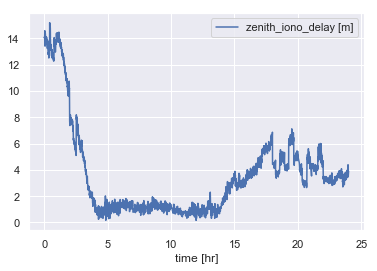

In [275]:
# PLOT iono delay [m] over time,
sns.set()
iono_delay_time_series.plot()
